<a href="https://colab.research.google.com/github/mnijhuis-dnb/XAI/blob/main/Explainable%20AI.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Explainable AI 

*	Permutation importance with ELI5
*	Partial dependency plots
*	Shapley values

<br/>

6 June 2023  

**Instructors**  
Michiel Nijhuis (m.nijhuis@dnb.nl)  

### Data loading

For this tutorial we will use the US census income dataset: 
https://archive.ics.uci.edu/ml/datasets/Census-Income+%28KDD%29

We will start with the installation of the packages we are going to use

In [1]:
!pip install shap
!pip install eli5

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 572.6/572.6 kB 9.8 MB/s eta 0:00:00
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 216.2/216.2 kB 4.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for eli5: filename=eli5-0.13.0-py2.py3-none-any.whl size=107730 sha256=a1048b02610e792dda68c29d462f90bba40e0655ae4798f3d4222d84feee1a2c
  Stored in directory: /root/.cache/pip/wheels/b8/58/ef/2cf4c306898c2338d51540e0922c8e0d6028e07007085c0004
Successfully built eli5


In [2]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier

Downloading and installing the data which will be used

In [3]:
!gdown 131MoEFF9OEY9x61yMi_2fZmzJnt4P4qu

Downloading...
From: https://drive.google.com/uc?id=131MoEFF9OEY9x61yMi_2fZmzJnt4P4qu
To: /content/census-income.data
100% 104M/104M [00:01<00:00, 71.9MB/s] 


Reading in the data

In [4]:
dtypes = [
	('age', 'float32'), ('class of worker', 'category'), ('detailed industry recode', 'category'), 
	('detailed occupation recode', 'category'), ('education', 'category'), ('wage per hour', 'float32'), 
	('enroll in edu inst last wk', 'category'), ('marital stat', 'category'), ('major industry code', 'category'), 
	('major occupation code', 'category'), ('race', 'category'), ('hispanic origin', 'category'), 
	('sex', 'category'), ('member of a labor union', 'category'), ('reason for unemployment', 'category'), 
	('full or part time employment stat', 'category'), ('capital gains', 'float32'), 
	('capital losses', 'float32'), ('dividends from stocks', 'float32'), ('tax filer stat', 'category'), 
	('region of previous residence', 'category'), ('state of previous residence', 'category'), 
	('detailed household and family stat', 'category'), ('detailed household summary in household', 'category'), 
	('instance weight_ignore', 'float32'), ('migration code-change in msa', 'category'), 
	('migration code-change in reg', 'category'), ('migration code-move within reg', 'category'), 
	('live in this house 1 year ago', 'category'), ('migration prev res in sunbelt', 'category'), 
	('num persons worked for employer', 'float32'),	('family members under 18', 'category'), 
	('country of birth father', 'category'), ('country of birth mother', 'category'), 
	('country of birth self', 'category'), ('citizenship', 'category'), ('own business or self employed', 'category'), 
	('fill inc questionnaire for veteran\'s admin', 'category'), ('veterans benefits', 'category'), 
	('weeks worked in year', 'float32'), ('year', 'category'), ('targets', 'category')]

raw_data = pd.read_csv('/content/census-income.data', names=[d[0] for d in dtypes], dtype=dict(dtypes))

edu_code = {"Children": 0,
            "Less than 1st grade": 1,  
            "1st 2nd 3rd or 4th grade": 2,  
            "5th or 6th grade": 3, 
            "7th and 8th grade": 4, 
            "9th grade": 5, 
            "10th grade": 6, 
            "11th grade": 7, 
            "12th grade no diploma": 8, 
            "High school graduate": 9,
            "Some college but no degree": 10,
            "Associates degree-academic program": 11, 
            "Associates degree-occup /vocational": 12,
            "Bachelors degree(BA AB BS)": 13,
            "Masters degree(MA MS MEng MEd MSW MBA)": 14,  
            "Prof school degree (MD DDS DVM LLB JD)": 15,
            "Doctorate degree(PhD EdD)": 15}
raw_data['education-num'] = np.array([edu_code[v.strip()] for v in raw_data['education']]).astype('float32')
dtypes.append(('education-num','float32'))

targets, target_value = pd.factorize(raw_data['targets'])
raw_data = raw_data.drop(columns=['instance weight_ignore', 'targets'])

Some data cleanup

In [5]:
# remove some of the data to make it calculate quicker
data = raw_data.drop(columns=['detailed industry recode', 'detailed occupation recode', 
                              'major industry code', 'major occupation code', 'education', 
                              'country of birth father',  'country of birth mother', 
                              'country of birth self', 'state of previous residence', 
                              'detailed household and family stat'])
data_for_plot = data.copy()
binary_columns = ['sex','member of a labor union','live in this house 1 year ago',
                   'migration prev res in sunbelt','own business or self employed',
                   'fill inc questionnaire for veteran\'s admin','veterans benefits',
                   'year']

binary_data = data[binary_columns].copy()
categorical_data = data.select_dtypes(include=['category']).drop(columns=binary_data)
numerical_data = data.select_dtypes(include=['float32'])

binary_data[(binary_data==' 2') | (binary_data==' ?') | (binary_data==' Not in universe') | (binary_data==' Not in universe under 1 year old')] = np.nan

binary_data = (binary_data.apply(lambda x: pd.factorize(x)[0]))

categorical_data = categorical_data.apply(lambda x : pd.factorize(x)[0])
data = pd.DataFrame(np.hstack((categorical_data,numerical_data.values, binary_data.values)),
                     columns=list(categorical_data.columns) + list(numerical_data.columns) + list(binary_data.columns))
data = data.reindex(columns=data_for_plot.columns)

Making a test-train split

In [6]:
train_x, val_x, train_y, val_y = train_test_split(data, pd.Series(targets), random_state=99)

index = np.random.permutation(np.hstack((train_y.index.values[train_y==1],np.random.permutation(train_y.index.values[train_y==0])))[:2*np.sum(train_y==1)])
train_x_new = train_x.loc[index]
train_y_new = train_y.loc[index]

data.head()

age  class of worker  wage per hour  enroll in edu inst last wk  \
0  73.0              0.0            0.0                         0.0   
1  58.0              1.0            0.0                         0.0   
2  18.0              0.0            0.0                         1.0   
3   9.0              0.0            0.0                         0.0   
4  10.0              0.0            0.0                         0.0   

   marital stat  race  hispanic origin  sex  member of a labor union  \
0           0.0   0.0              0.0  0.0                     -1.0   
1           1.0   0.0              0.0  1.0                     -1.0   
2           2.0   1.0              0.0  0.0                     -1.0   
3           2.0   0.0              0.0  0.0                     -1.0   
4           2.0   0.0              0.0  0.0                     -1.0   

   reason for unemployment  ...  migration prev res in sunbelt  \
0                      0.0  ...                           -1.0   
1                      0.0  ...                            0.0   
2                      0.0  ...                           -1.0   
3                      0.0  ...                           -1.0   
4                      0.0  ...                           -1.0   

   num persons worked for employer  family members under 18  citizenship  \
0                              0.0                      0.0          0.0   
1                              1.0                      0.0          0.0   
2                              0.0                      0.0          1.0   
3                              0.0                      1.0          0.0   
4                              0.0                      1.0          0.0   

   own business or self employed  fill inc questionnaire for veteran's admin  \
0                            0.0                                        -1.0   
1                            0.0                                        -1.0   
2                            0.0                                        -1.0   
3                            0.0                                        -1.0   
4                            0.0                                        -1.0   

   veterans benefits  weeks worked in year  year  education-num  
0               -1.0                   0.0   0.0            9.0  
1               -1.0                  52.0   1.0           10.0  
2               -1.0                   0.0   0.0            6.0  
3                0.0                   0.0   1.0            0.0  
4                0.0                   0.0   1.0            0.0  

[5 rows x 31 columns]

Building a model...

In [7]:
my_model = RandomForestClassifier(random_state=99, min_samples_split=500, max_leaf_nodes=50, oob_score=True).fit(train_x_new, train_y_new)
print(f'Model accuracy: {np.round(np.sum(my_model.predict(val_x)==val_y)/len(val_y)*100,1)}%')
print(f'Model recall: {np.round(np.sum((my_model.predict(val_x)==1) & (val_y==1))/np.sum(val_y==1)*100,1)}%')

Model accuracy: 83.7%
Model recall: 87.7%


### ELI5
Calculating feature importance with eli5:

In [8]:
import eli5
from eli5.sklearn import PermutationImportance

perm = PermutationImportance(my_model, random_state=1, scoring='recall').fit(train_x_new, train_y_new)
eli5.show_weights(perm, feature_names = data.columns.to_list(), top=50)

### Partial dependence plots
Now we will create a couple of partial dependence plots

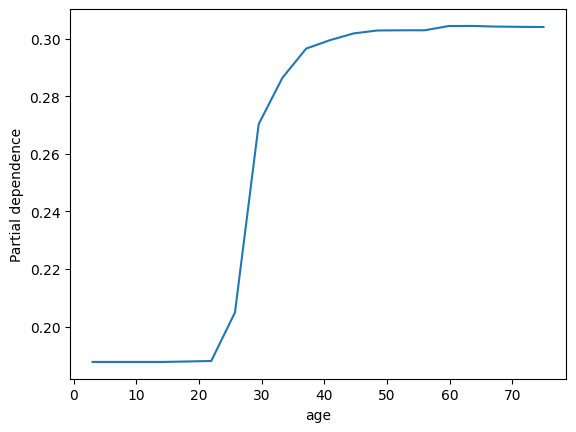

In [9]:
import matplotlib.pyplot as plt
from sklearn.inspection import PartialDependenceDisplay

pdp_age = PartialDependenceDisplay.from_estimator(my_model, val_x, ['age'], grid_resolution=20)
plt.setp(pdp_age.deciles_vlines_, visible=False);

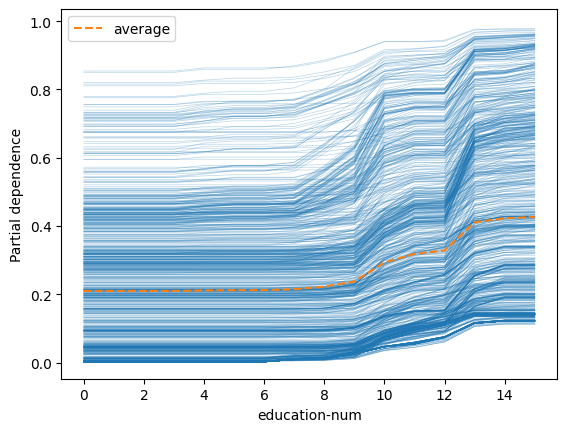

In [10]:
pdp_education = PartialDependenceDisplay.from_estimator(my_model, val_x, ['education-num'], kind='both',  grid_resolution=20)
plt.setp(pdp_education.deciles_vlines_, visible=False);

Also works with contour plots

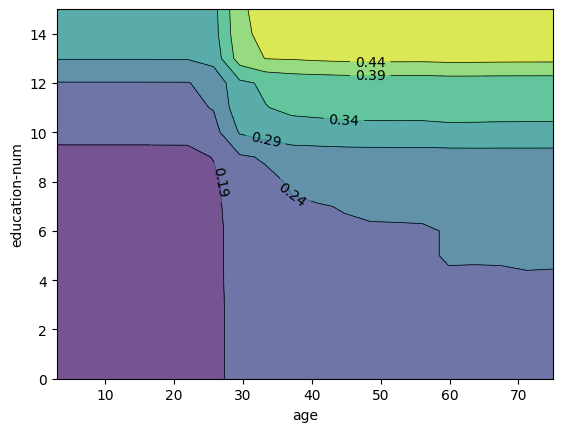

In [11]:
features_to_plot = ('age', 'education-num')

pdp_2d = PartialDependenceDisplay.from_estimator(my_model, val_x, [features_to_plot], grid_resolution=20)
plt.setp(pdp_2d.deciles_vlines_, visible=False);

### SHAP
Now we will take a look at the Shapley values for a single row

In [12]:
import shap

In [13]:
row_number = 79
data_for_prediction = val_x.iloc[row_number]  
my_model.predict_proba(data_for_prediction.values.reshape(1, -1))

X does not have valid feature names, but RandomForestClassifier was fitted with feature names


array([[0.72153834, 0.27846166]])

In [14]:
explainer = shap.TreeExplainer(my_model)
shap_values = explainer.shap_values(data_for_prediction)
shap_values

[array([-2.17908937e-02,  5.60963153e-02, -8.26661138e-04, -1.05479824e-03,
        -6.29558247e-03, -8.53352984e-04, -1.10445624e-03,  9.15651110e-02,
         8.24658121e-04, -2.91706020e-05,  5.80903171e-03,  1.87391599e-02,
         3.50689403e-03,  3.76779667e-02, -2.10612934e-02, -2.38926134e-04,
        -3.22415644e-02, -2.19488770e-04, -2.41059774e-04, -1.76294779e-04,
        -4.19349997e-04, -2.26604548e-04, -2.83383890e-02, -6.26870770e-03,
        -3.58003087e-04, -1.94239376e-03,  1.38909808e-04,  3.92338784e-04,
         1.35126718e-01, -3.31834258e-04, -4.14109258e-03]),
 array([ 2.17908937e-02, -5.60963153e-02,  8.26661138e-04,  1.05479824e-03,
         6.29558247e-03,  8.53352984e-04,  1.10445624e-03, -9.15651110e-02,
        -8.24658121e-04,  2.91706020e-05, -5.80903171e-03, -1.87391599e-02,
        -3.50689403e-03, -3.76779667e-02,  2.10612934e-02,  2.38926134e-04,
         3.22415644e-02,  2.19488770e-04,  2.41059774e-04,  1.76294779e-04,
         4.19349997e-04,  2

SHAP also has nice visualizations for these values

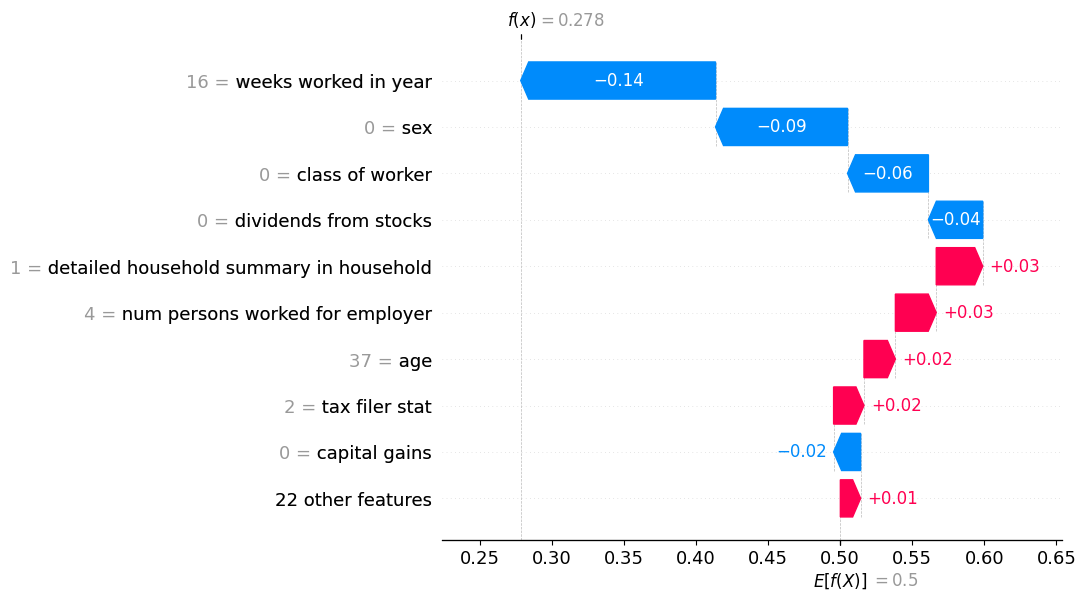

In [15]:
shap.initjs()
shap.waterfall_plot(shap.Explanation(values=shap_values[1], 
                                     base_values=explainer.expected_value[1], 
                                     data=val_x.iloc[row_number],  
                                     feature_names=data_for_plot.loc[val_x.index[row_number]].index.tolist()))

In [16]:
shap.initjs()
shap.force_plot(explainer.expected_value[1], shap_values[1], data_for_plot.loc[val_x.index[row_number]])

For non tree based models we can use the KernelExplainer to get an approximate result

In [17]:
shap.initjs()
k_explainer = shap.KernelExplainer(my_model.predict, shap.kmeans(val_x, 54))
k_shap_values = k_explainer.shap_values(data_for_prediction)
shap.force_plot(k_explainer.expected_value, k_shap_values, data_for_plot.loc[val_x.index[row_number]])

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Calculating the Shapley values of 10000 random rows

In [18]:
explainer = shap.TreeExplainer(my_model)
random_subset = val_x.sample(n=10000)
shap_values = explainer.shap_values(random_subset)

Now we can plot the results for multiple the rows

In [19]:
shap.initjs()
shap.force_plot(explainer.expected_value[1], shap_values[1][:1000], data_for_plot.loc[random_subset.index[:1000]])

We can get a summary of the Shapley values as follows


No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


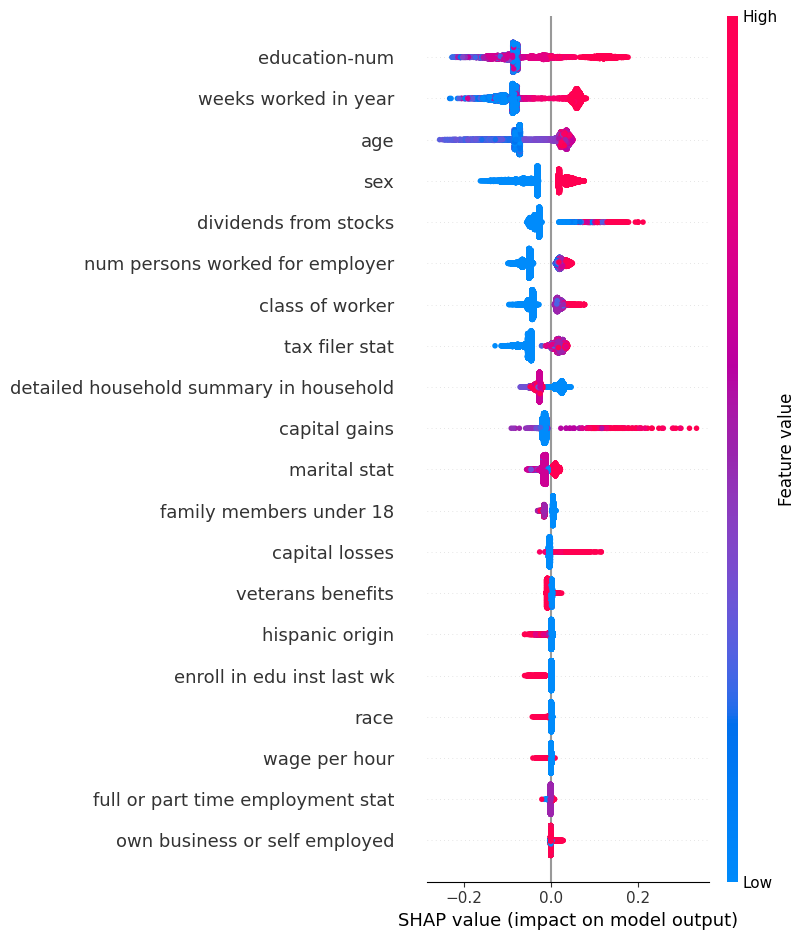

In [20]:
shap_values = explainer.shap_values(random_subset)
shap.summary_plot(shap_values[1], random_subset)

Or for the combined features

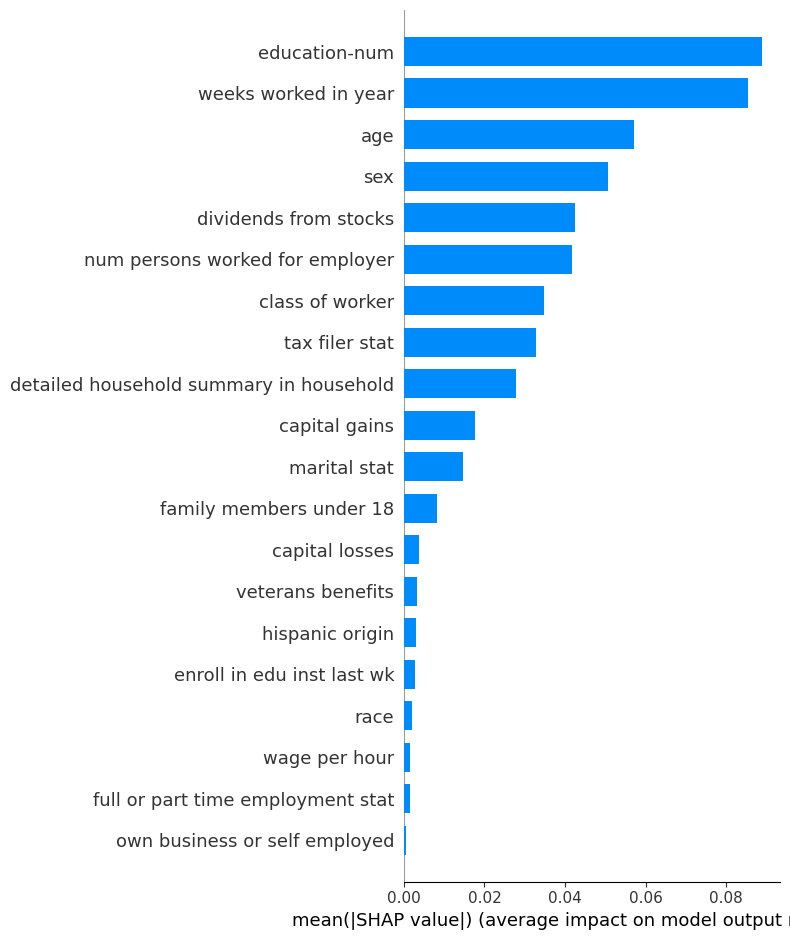

In [21]:
shap.summary_plot(shap_values[0], random_subset, plot_type='bar')

Or for the dependence between 2 features

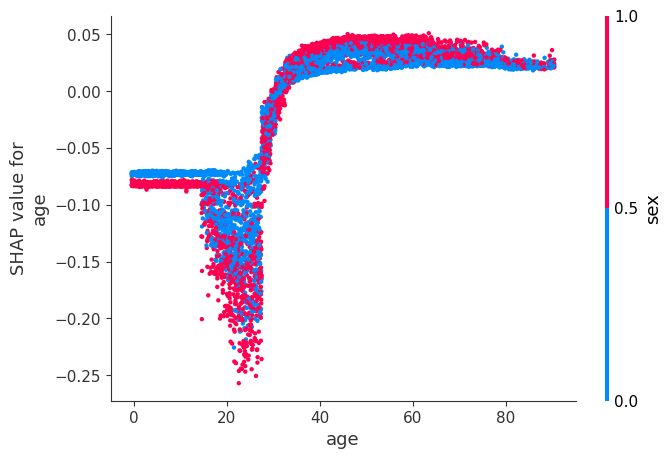

In [22]:
shap.dependence_plot('age', shap_values[1], random_subset, interaction_index='sex', x_jitter=1, dot_size=10)

In [23]:
data.columns

Index(['age', 'class of worker', 'wage per hour', 'enroll in edu inst last wk',
       'marital stat', 'race', 'hispanic origin', 'sex',
       'member of a labor union', 'reason for unemployment',
       'full or part time employment stat', 'capital gains', 'capital losses',
       'dividends from stocks', 'tax filer stat',
       'region of previous residence',
       'detailed household summary in household',
       'migration code-change in msa', 'migration code-change in reg',
       'migration code-move within reg', 'live in this house 1 year ago',
       'migration prev res in sunbelt', 'num persons worked for employer',
       'family members under 18', 'citizenship',
       'own business or self employed',
       'fill inc questionnaire for veteran's admin', 'veterans benefits',
       'weeks worked in year', 'year', 'education-num'],
      dtype='object')

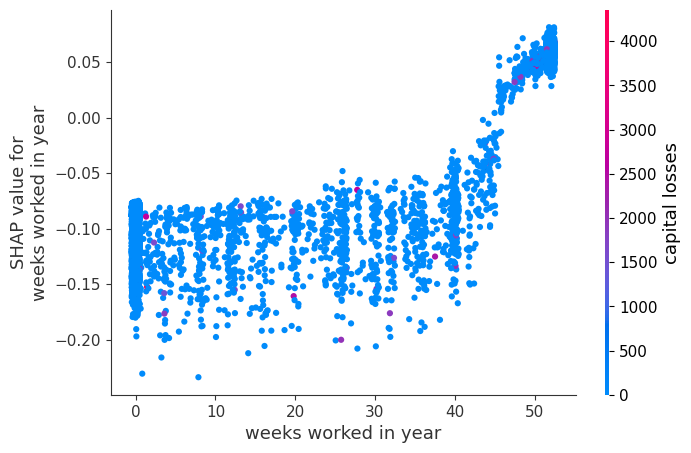

In [24]:
shap.dependence_plot('weeks worked in year', shap_values[1], random_subset, interaction_index='capital losses', x_jitter=1, dot_size=20)

Check for fairness

In [25]:
print(f"Times more likely that a male makes more than 50k = {targets[data['sex']==1].mean()/targets[data['sex']==0].mean():.2}")

Times more likely that a male makes more than 50k = 4.0


In [26]:
print(f"Times more likely that a male makes more than 50k = {my_model.predict(data[data['sex']==1]).mean()/my_model.predict(data[data['sex']==0]).mean():.2}")

Times more likely that a male makes more than 50k = 3.0


In [27]:
print('original accuracy and recall')
print(f'Model accuracy: {np.round(np.sum(my_model.predict(val_x)==val_y)/len(val_y)*100,1)}%')
print(f'Model recall: {np.round(np.sum((my_model.predict(val_x)==1) & (val_y==1))/np.sum(val_y==1)*100,1)}%')

original accuracy and recall
Model accuracy: 83.7%
Model recall: 87.7%


In [28]:
feature_names = data_for_plot.loc[val_x.index].columns.to_list()

new_data = data.copy()
new_data['sex'] = 0
train_x, val_x, train_y, val_y = train_test_split(new_data, pd.Series(targets), random_state=99)

index = np.random.permutation(np.hstack((train_y.index.values[train_y==1],np.random.permutation(train_y.index.values[train_y==0])))[:2*np.sum(train_y==1)])
train_x_new = train_x.loc[index]
train_y_new = train_y.loc[index]

my_model = RandomForestClassifier(random_state=99, min_samples_split=500, max_leaf_nodes=50, oob_score=True).fit(train_x_new, train_y_new)

explainer = shap.TreeExplainer(my_model)
random_subset = val_x.sample(n=10000)
shap_values = explainer.shap_values(random_subset)

print(f'Model accuracy: {np.round(np.sum(my_model.predict(val_x)==val_y)/len(val_y)*100,1)}%')
print(f'Model recall: {np.round(np.sum((my_model.predict(val_x)==1) & (val_y==1))/np.sum(val_y==1)*100,1)}%')

Model accuracy: 82.8%
Model recall: 87.6%


In [29]:
print(f"Times more likely that a male makes more than 50k = {my_model.predict(data[data['sex']==1]).mean()/my_model.predict(data[data['sex']==0]).mean():.2}")

Times more likely that a male makes more than 50k = 1.8


FixedFormatter should only be used together with FixedLocator


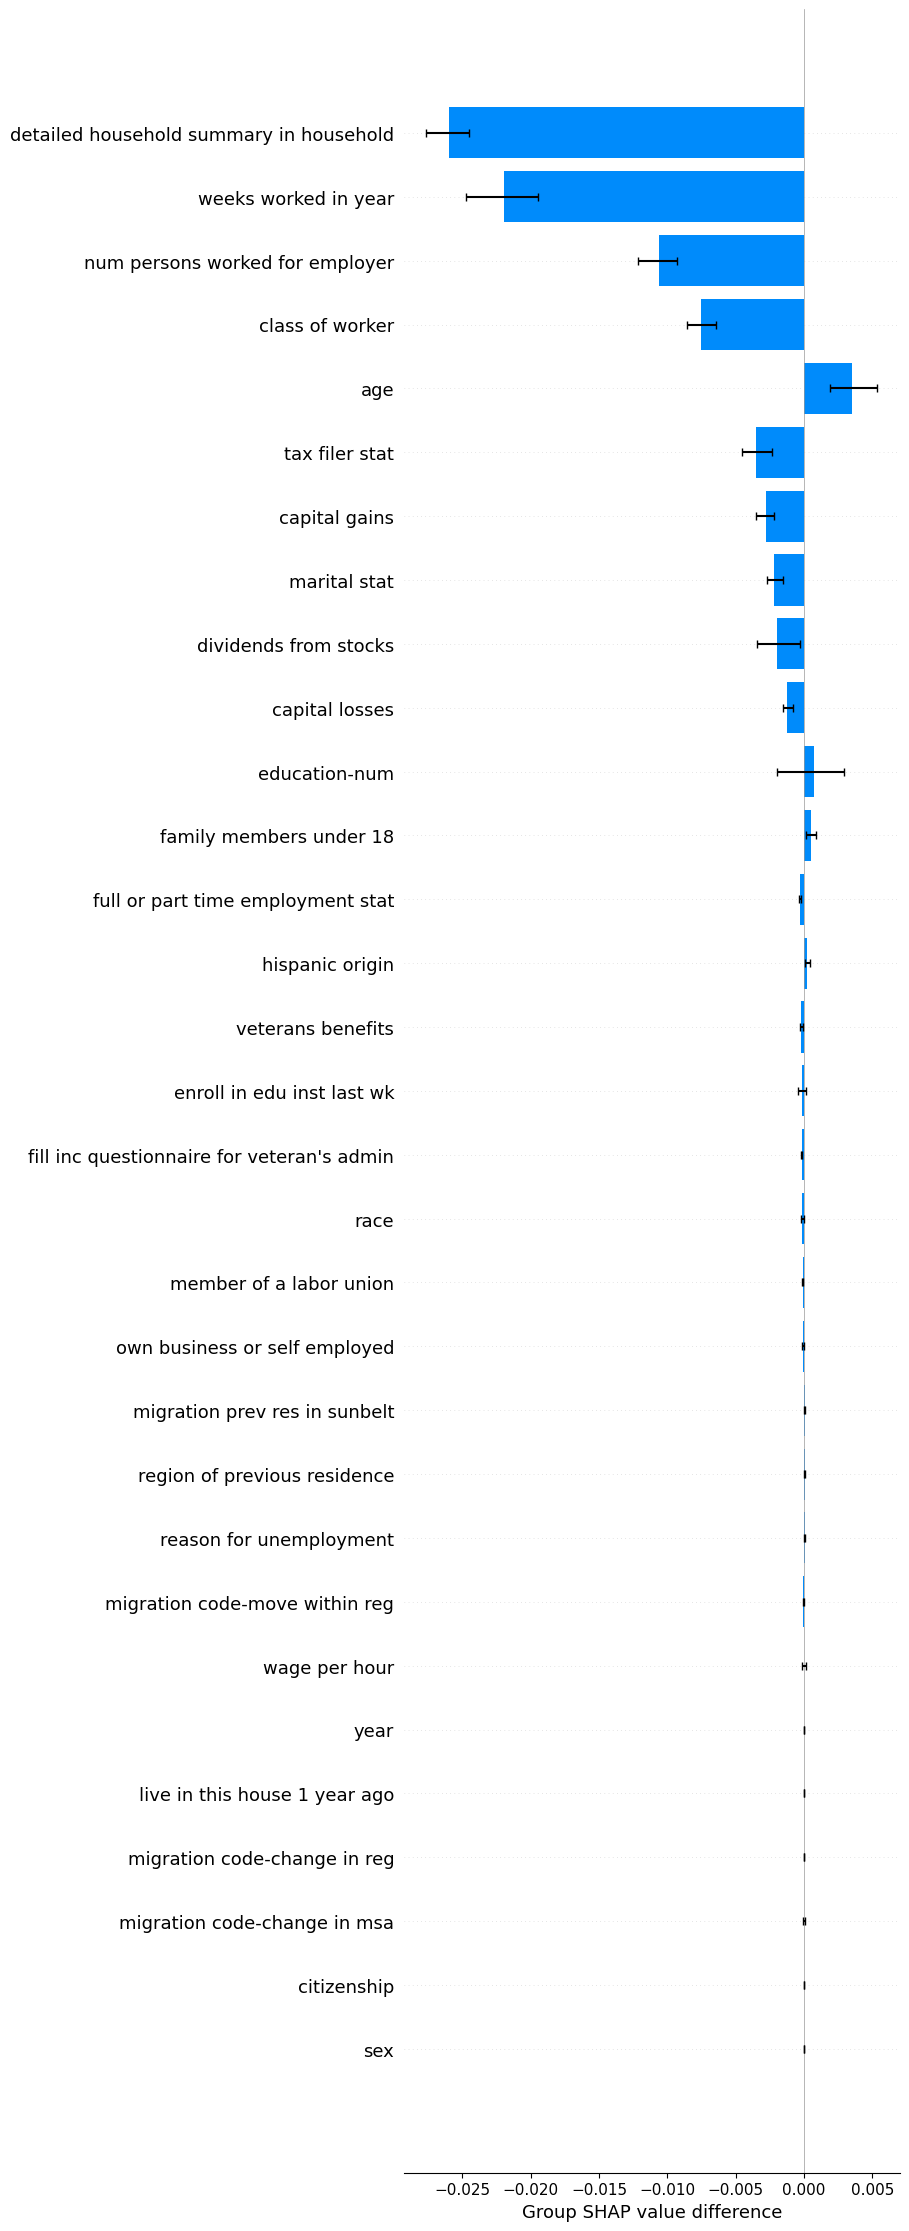

In [30]:
shap.group_difference_plot(shap_values[1], data_for_plot.loc[random_subset.index, 'sex']==' Female', feature_names)

In [31]:
feature_names = data_for_plot.loc[val_x.index].columns.to_list()

new_data['detailed household summary in household'] = 0
train_x, val_x, train_y, val_y = train_test_split(new_data, pd.Series(targets), random_state=99)

index = np.random.permutation(np.hstack((train_y.index.values[train_y==1],np.random.permutation(train_y.index.values[train_y==0])))[:2*np.sum(train_y==1)])
train_x_new = train_x.loc[index]
train_y_new = train_y.loc[index]

my_model = RandomForestClassifier(random_state=99, min_samples_split=500, max_leaf_nodes=50, oob_score=True).fit(train_x_new, train_y_new)

explainer = shap.TreeExplainer(my_model)
random_subset = val_x.sample(n=10000)
shap_values = explainer.shap_values(random_subset)

print(f'Model accuracy: {np.round(np.sum(my_model.predict(val_x)==val_y)/len(val_y)*100,1)}%')
print(f'Model recall: {np.round(np.sum((my_model.predict(val_x)==1) & (val_y==1))/np.sum(val_y==1)*100,1)}%')

Model accuracy: 83.1%
Model recall: 85.6%


In [32]:
print(f"Times more likely that a male makes more than 50k = {my_model.predict(data[data['sex']==1]).mean()/my_model.predict(data[data['sex']==0]).mean():.2}")

Times more likely that a male makes more than 50k = 1.4
